In [51]:
import numpy as np
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib as mpl

In [52]:
GPUkernel = """
#include <math.h>

__device__ float dot(float3 a, float3 b)
{
    return a.x * b.x + a.y * b.y + a.z * b.z;
}

__device__ float3 normalize(float3 v)
{
    float len = sqrtf(dot(v, v));
    return make_float3(v.x / len, v.y / len, v.z / len);
}

__device__ float3 reflect(float3 v, float3 n)
{
    return make_float3(v.x - 2.0f * dot(v, n) * n.x, v.y - 2.0f * dot(v, n) * n.y, v.z - 2.0f * dot(v, n) * n.z);
}

__device__ float3 mix(float3 a, float3 b, float t)
{
    return make_float3(a.x * (1.0f - t) + b.x * t, a.y * (1.0f - t) + b.y * t, a.z * (1.0f - t) + b.z * t);
}

__device__ bool intersect_sphere(float3 ro, float3 rd, float3 sphere_c, float sphere_r, float &t_hit)
{
    float3 oc = make_float3(ro.x - sphere_c.x, ro.y - sphere_c.y, ro.z - sphere_c.z);
    float b = dot(oc, rd);
    float c = dot(oc, oc) - sphere_r * sphere_r;
    
    if (b * b - c < 0.0f) return false;
    
    float disc = sqrtf(b * b - c);
    float t0 = -b - disc;
    float t1 = -b + disc;
    
    if (t0 > 0.0f && t1 > 0.0f) 
    {
        t_hit = fminf(t0, t1);
        return true;
    } 
    else if (t0 > 0.0f) 
    {
        t_hit = t0;
        return true;
    } 
    else if (t1 > 0.0f) 
    {
        t_hit = t1;
        return true;
    }
    
    return false;
}

__device__ bool intersect_plane(float3 ro, float3 rd, float3 p_normal, float p_dist, float &t_hit)
{
    float denom = dot(p_normal, rd);
    
    if (fabsf(denom) < 1e-6f) return false;
    
    t_hit = -(dot(p_normal, ro) + p_dist) / denom;
    return t_hit > 0.0f;
}

__device__ float3 floor_pattern(float x, float z)
{
    int check = (int(floorf(x)) + int(floorf(z))) % 2;
    return check ? make_float3(0.8f, 0.8f, 0.8f) : make_float3(0.3f, 0.3f, 0.3f);
}

__device__ float3 sky_color(float3 dir)
{
    float t = 0.5f * (dir.y + 1.0f);
    float3 sky_blue = make_float3(0.5f, 0.7f, 1.0f);
    float3 white = make_float3(1.0f, 1.0f, 1.0f);
    return mix(white, sky_blue, t);
}

__global__ void render(float *disp, int img_w, int img_h, float time)
{
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row >= img_h || col >= img_w)
    {
        return;
    }

    int pix_location = row * img_w * 3 + col * 3;
    
    float aspect_ratio = float(img_w) / float(img_h);

    float u = (2.0f * (col + 0.5f) / float(img_w) - 1.0f) * aspect_ratio;
    float v = 1.0f - 2.0f * (row + 0.5f) / float(img_h);

    float3 cam_pos = make_float3(0.0f, 1.0f, -5.0f);
    float3 look_at = make_float3(0.0f, 0.0f, 0.0f);
    float3 up = make_float3(0.0f, 1.0f, 0.0f);
    
    float3 cam_dir = normalize(make_float3(look_at.x - cam_pos.x, look_at.y - cam_pos.y, look_at.z - cam_pos.z));
    
    float3 cam_right = normalize(make_float3(cam_dir.z, 0.0f, -cam_dir.x));
    
    float3 cam_up = normalize(make_float3(cam_dir.y * cam_right.z - cam_dir.z * cam_right.y, cam_dir.z * cam_right.x - cam_dir.x * cam_right.z, cam_dir.x * cam_right.y - cam_dir.y * cam_right.x));
    
    float focal_length = 1.0f;
    float3 ray_dir = normalize(make_float3(cam_dir.x * focal_length + cam_right.x * u + cam_up.x * v, cam_dir.y * focal_length + cam_right.y * u + cam_up.y * v, cam_dir.z * focal_length + cam_right.z * u + cam_up.z * v));

    float3 light_pos = make_float3(5.0f, 10.0f, -5.0f);
    float3 surrounding_light = make_float3(0.1f, 0.1f, 0.1f);
    
    float3 sphere1_center = make_float3(2.0f * sinf(time), 1.5f + 0.5f * cosf(time * 0.7f), 2.0f * cosf(time * 0.5f));
    float sphere1_radius = 1.0f;
    float3 sphere1_color = make_float3(0.9f, 0.2f, 0.2f);
    
    float3 sphere2_center = make_float3(-1.5f, 0.7f, 1.0f);
    float sphere2_radius = 0.7f;
    float3 sphere2_color = make_float3(0.2f, 0.2f, 0.9f);
    
    float3 sphere3_center = make_float3(0.0f, 0.4f, 3.0f);
    float sphere3_radius = 0.4f;
    float3 sphere3_color = make_float3(0.3f, 0.8f, 0.3f);

    float3 floor_normal = make_float3(0.0f, 1.0f, 0.0f);
    float floor_dist = 0.0f;
    
    float t_closest = 1e10f;
    float3 color = sky_color(ray_dir);
    float3 normal;
    float3 hit_point;
    float3 material_color;
    float specular_power = 0.0f;
    
    float t_hit;
    bool hit_something = false;
    
    if (intersect_sphere(cam_pos, ray_dir, sphere1_center, sphere1_radius, t_hit) && t_hit < t_closest) 
    {
        t_closest = t_hit;
        hit_point = make_float3(cam_pos.x + t_hit * ray_dir.x, cam_pos.y + t_hit * ray_dir.y, cam_pos.z + t_hit * ray_dir.z);
        normal = normalize(make_float3(hit_point.x - sphere1_center.x, hit_point.y - sphere1_center.y, hit_point.z - sphere1_center.z));
        material_color = sphere1_color;
        specular_power = 32.0f;
        hit_something = true;
    }
    
    if (intersect_sphere(cam_pos, ray_dir, sphere2_center, sphere2_radius, t_hit) && t_hit < t_closest) 
    {
        t_closest = t_hit;
        hit_point = make_float3(cam_pos.x + t_hit * ray_dir.x, cam_pos.y + t_hit * ray_dir.y, cam_pos.z + t_hit * ray_dir.z);
        normal = normalize(make_float3(hit_point.x - sphere2_center.x, hit_point.y - sphere2_center.y, hit_point.z - sphere2_center.z));
        material_color = sphere2_color;
        specular_power = 64.0f;
        hit_something = true;
    }
    
    if (intersect_sphere(cam_pos, ray_dir, sphere3_center, sphere3_radius, t_hit) && t_hit < t_closest) 
    {
        t_closest = t_hit;
        hit_point = make_float3(cam_pos.x + t_hit * ray_dir.x, cam_pos.y + t_hit * ray_dir.y, cam_pos.z + t_hit * ray_dir.z);
        normal = normalize(make_float3(hit_point.x - sphere3_center.x, hit_point.y - sphere3_center.y, hit_point.z - sphere3_center.z));
        material_color = sphere3_color;
        specular_power = 16.0f;
        hit_something = true;
    }
    
    if (intersect_plane(cam_pos, ray_dir, floor_normal, floor_dist, t_hit) && t_hit < t_closest) 
    {
        t_closest = t_hit;
        hit_point = make_float3(cam_pos.x + t_hit * ray_dir.x, cam_pos.y + t_hit * ray_dir.y, cam_pos.z + t_hit * ray_dir.z);
        normal = floor_normal;
        material_color = floor_pattern(hit_point.x, hit_point.z);
        specular_power = 4.0f;
        hit_something = true;
    }
    
    if (hit_something) 
    {
        float3 light_dir = normalize(make_float3(light_pos.x - hit_point.x, light_pos.y - hit_point.y, light_pos.z - hit_point.z));
        
        bool in_shadow = false;
        float t_shadow;
        
        if (intersect_sphere(hit_point, light_dir, sphere1_center, sphere1_radius, t_shadow) || intersect_sphere(hit_point, light_dir, sphere2_center, sphere2_radius, t_shadow) || intersect_sphere(hit_point, light_dir, sphere3_center, sphere3_radius, t_shadow)) 
        {
            in_shadow = true;
        }

        float diffuse = fmaxf(0.0f, dot(normal, light_dir));

        float3 reflect_dir = reflect(make_float3(-light_dir.x, -light_dir.y, -light_dir.z), normal);
        float spec = powf(fmaxf(0.0f, dot(reflect_dir, make_float3(-ray_dir.x, -ray_dir.y, -ray_dir.z))), specular_power);
        
        if (in_shadow) 
        {
            color = make_float3(material_color.x * surrounding_light.x, material_color.y * surrounding_light.y, material_color.z * surrounding_light.z);
        } 
        else 
        {
            color = make_float3(fminf(1.0f, material_color.x * (surrounding_light.x + diffuse) + spec), fminf(1.0f, material_color.y * (surrounding_light.y + diffuse) + spec), fminf(1.0f, material_color.z * (surrounding_light.z + diffuse) + spec));
        }
    }
    
    color.x = powf(color.x, 1.0f/2.2f);
    color.y = powf(color.y, 1.0f/2.2f);
    color.z = powf(color.z, 1.0f/2.2f);
    
    disp[pix_location + 0] = color.x;
    disp[pix_location + 1] = color.y;
    disp[pix_location + 2] = color.z;
}

"""

In [53]:
module = SourceModule(GPUkernel)
render = module.get_function("render")

img_w = 1920
img_h = 1080

n_pix = img_w * img_h
disp = np.zeros(3 * n_pix, dtype=np.float32)

threads = (16, 16, 1)
blocks = ((threads[0] + img_w - 1) // threads[0], (threads[1] + img_h - 1) // threads[1])

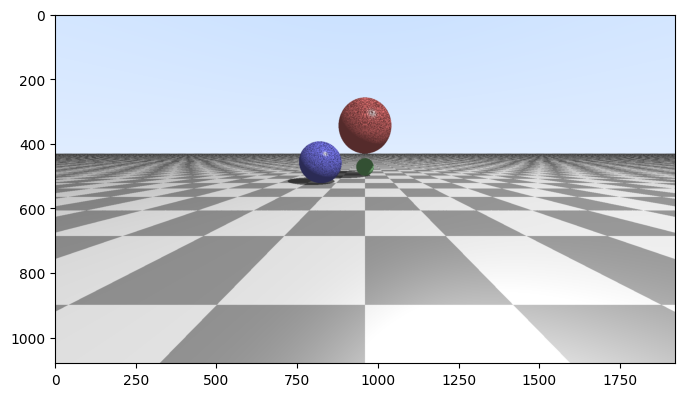

In [54]:
fig = plt.figure(figsize=(8, 6))
ax = plt.axes()
img_plot = ax.imshow(np.zeros((img_h, img_w, 3)))

def animate(frame):
    time = frame * 0.1
    render(drv.Out(disp), np.int32(img_w), np.int32(img_h), np.float32(time), block=threads, grid=blocks)
    img_data = disp.reshape(img_h, img_w, 3)
    img_plot.set_array(img_data)
    return [img_plot]

res = FuncAnimation(fig, animate, frames=90, interval=50, blit=True)

In [55]:
res.save('/mnt/d/CUDA/day37/intersection.gif', writer='pillow', fps=30)